# Algoritmus 2D Szenzor optimális pozíciójára

Vegyünk egy 2D hőtérképet kiindulásképpen.

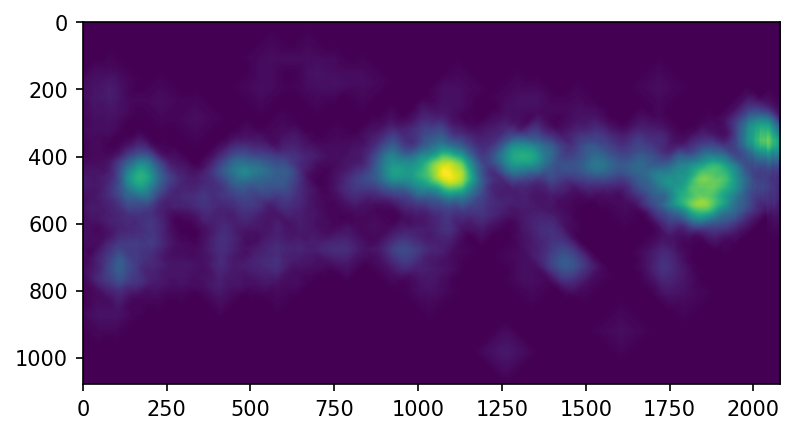

In [1]:
%matplotlib inline

import numpy as np
from string import ascii_lowercase
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Arc
import matplotlib as mpl
import seaborn as sns
from scipy import ndimage as ndi
from scipy.stats import mode
from skimage.feature import peak_local_max
from tqdm import tqdm
from place_me import optimize_v1, optimize_v2, optimize_v3

mpl.rcParams['figure.dpi'] = 150

data = np.loadtxt('data/heatmap2.txt')
data = 255 * data / data.max()
data = data[:, 1760:3840]
plt.imshow(data);

A hőtérképen kiválasztunk $n$ darab lokális maximum helyet, amelyen elhelyezünk $R$ sugarú köröket, ahol $n$ és $R$ az adott környezethez választott. (Példa: $n$-t az alkalmazást használó személyek számából kapjuk, $R$-t pedig úgy választjuk, hogy a valóságbeli mérete nagyjából az emberi kézzel azonos legyen). A hőtérkép nem determinisztikus, hanem valószínűségi jellegű, vagyis a generált körök pontos pozíciója ingadozik: a hőtérképen nagyobb értéken nagyobb valószínűséggel tartózkodik. A körök nem fedhetnek egymásba. Az alábbi kép egy $n = 6$ és $R = 40\,pixel$ felállást mutat.

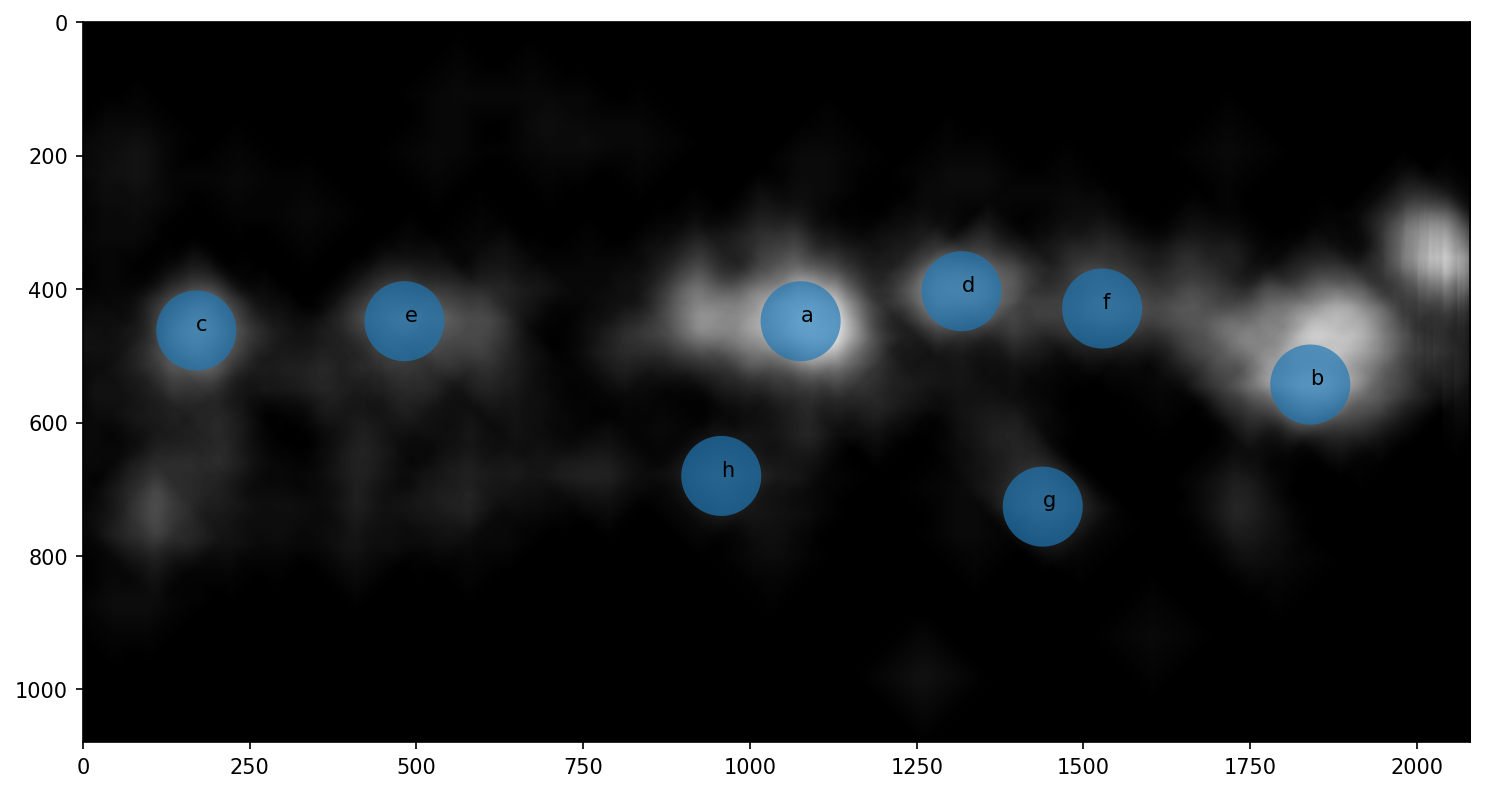

In [2]:
CIRCLE_RADIUS = 60
NUM_PEAKS = 8

image_max = ndi.maximum_filter(data, size=20, mode='constant')

peaks = peak_local_max(data, min_distance=CIRCLE_RADIUS * 2, num_peaks=NUM_PEAKS)
LETTERS = list(ascii_lowercase)[:NUM_PEAKS]

pairs = {l: p for l, p in zip(LETTERS, peaks)}

def plot_from_optimal_coords(data, peaks, arr=None, covs=None):
    colors = ["yellow", "red", "green"]
    fig, ax = plt.subplots(figsize=(10, 9))
    ax.imshow(data, cmap=plt.cm.gray)
    ax.autoscale(False)
    if arr is not None:
        for i in range(0, len(arr) - 1, 2):
            format_string = f"{colors[i // 2][0]}x"
            ax.plot(arr[i], arr[i + 1], format_string, markersize=25, markeredgewidth=3)       

    for i, (y, x) in enumerate(peaks):
        ax.text(x, y, LETTERS[i])
        circ = Circle((x, y), CIRCLE_RADIUS, alpha=0.7)
        ax.add_patch(circ)

    if covs is not None:
        for (k, sensor) in enumerate(covs):
            for (letter, data) in sensor.items():
                y, x = pairs[letter]
                for j in range(0, len(data) - 1, 2):
                    arc =  Arc((x, y),
                               CIRCLE_RADIUS * 2 + k * 15,
                               CIRCLE_RADIUS * 2 + k * 15,
                               0,
                               np.rad2deg(data[j]),
                               np.rad2deg(data[j + 1]),
                               color=colors[k],
                               alpha=1,
                               lw=2 + k
                              )
                    ax.add_patch(arc)

        

    fig.tight_layout()

    plt.show()

plot_from_optimal_coords(data, peaks)

Minden szenzor a hőtérkép kerülete mentén mozoghat. Egy szenzor esetén a lefedettséget úgy definiáljuk, hogy:
  - a lehető legtöbb kört lássuk
  - a körökből látott kerület szeletek összege a lehető legnagyobb


Újabb szenzorok hozzáadásánál egy adott körnél a már korábban lefedett területeket nem vesszük figyelembe - mivel ez nem hordoz új információt. A folyamat az, hogy addig adunk hozzá új szenzorokat, amíg minden kör látható legalább egy szenzor számára. A valószínűségi jelleg miatt ezt a szimulációt kellően sokszor futtatva megkapjuk, hogy mik lesznek az optimális szenzor pozíciók.

Formálisan:

Legyen $I(x) = 1$ ha $x > 0$, különben $0$, ún. indikátor függvény, továbbá jelölje egy adott $i$ objektum belátott részét $L_{i} = \frac{\sum x_i}{2\pi R}$. Ekkor $n$ darab objektum esetén az $LF$ teljes lefedettséget a következőképpen definiáljuk:
<center>
$LF = \sum_{i=1}^{n} (I(x_i) + L_i(x))$
</center>




A lentebbi ábrák ezzel a súlyfüggvénnyel számolt szimulációk eseteit mutatják, ahol piros, sárga és zöld markerek mutatják az optimális szenzor pozíciókat. Az alábbi példákban különböző számú szenzorra futtatjuk végig a szimulációkat, illetve az egyiknél 200-szor futtatjuk végig kissé különböző pozíciójú körökön, majd a KDE plotról a maximum értéket választjuk pozícióként, és azt ábrázoljuk.

#### Szimuláció 1 szenzorral:

In [ ]:
%env RUST_LOG=1
arr = np.c_[peaks, CIRCLE_RADIUS * np.ones(peaks.shape[0])]
options = {
    'width': data.shape[1],
    'height': data.shape[0],
    'resolution': 2880,
    'pixel_step': 20,
}
res, covs = optimize_v1(*arr.T, LETTERS, [0.0,  940.0, 1080.0, 930.0], **options)
plot_from_optimal_coords(data, peaks, res, covs)

#### Szimuláció 2 szenzorral:

env: RUST_LOG=1

🎯 covered 85.29414759976245% (13.647063615961994/16)
✅ optimal positions [
    Point {
        x: 1140.0,
        y: 1080.0,
    },
    Point {
        x: 840.0,
        y: 0.0,
    },
]


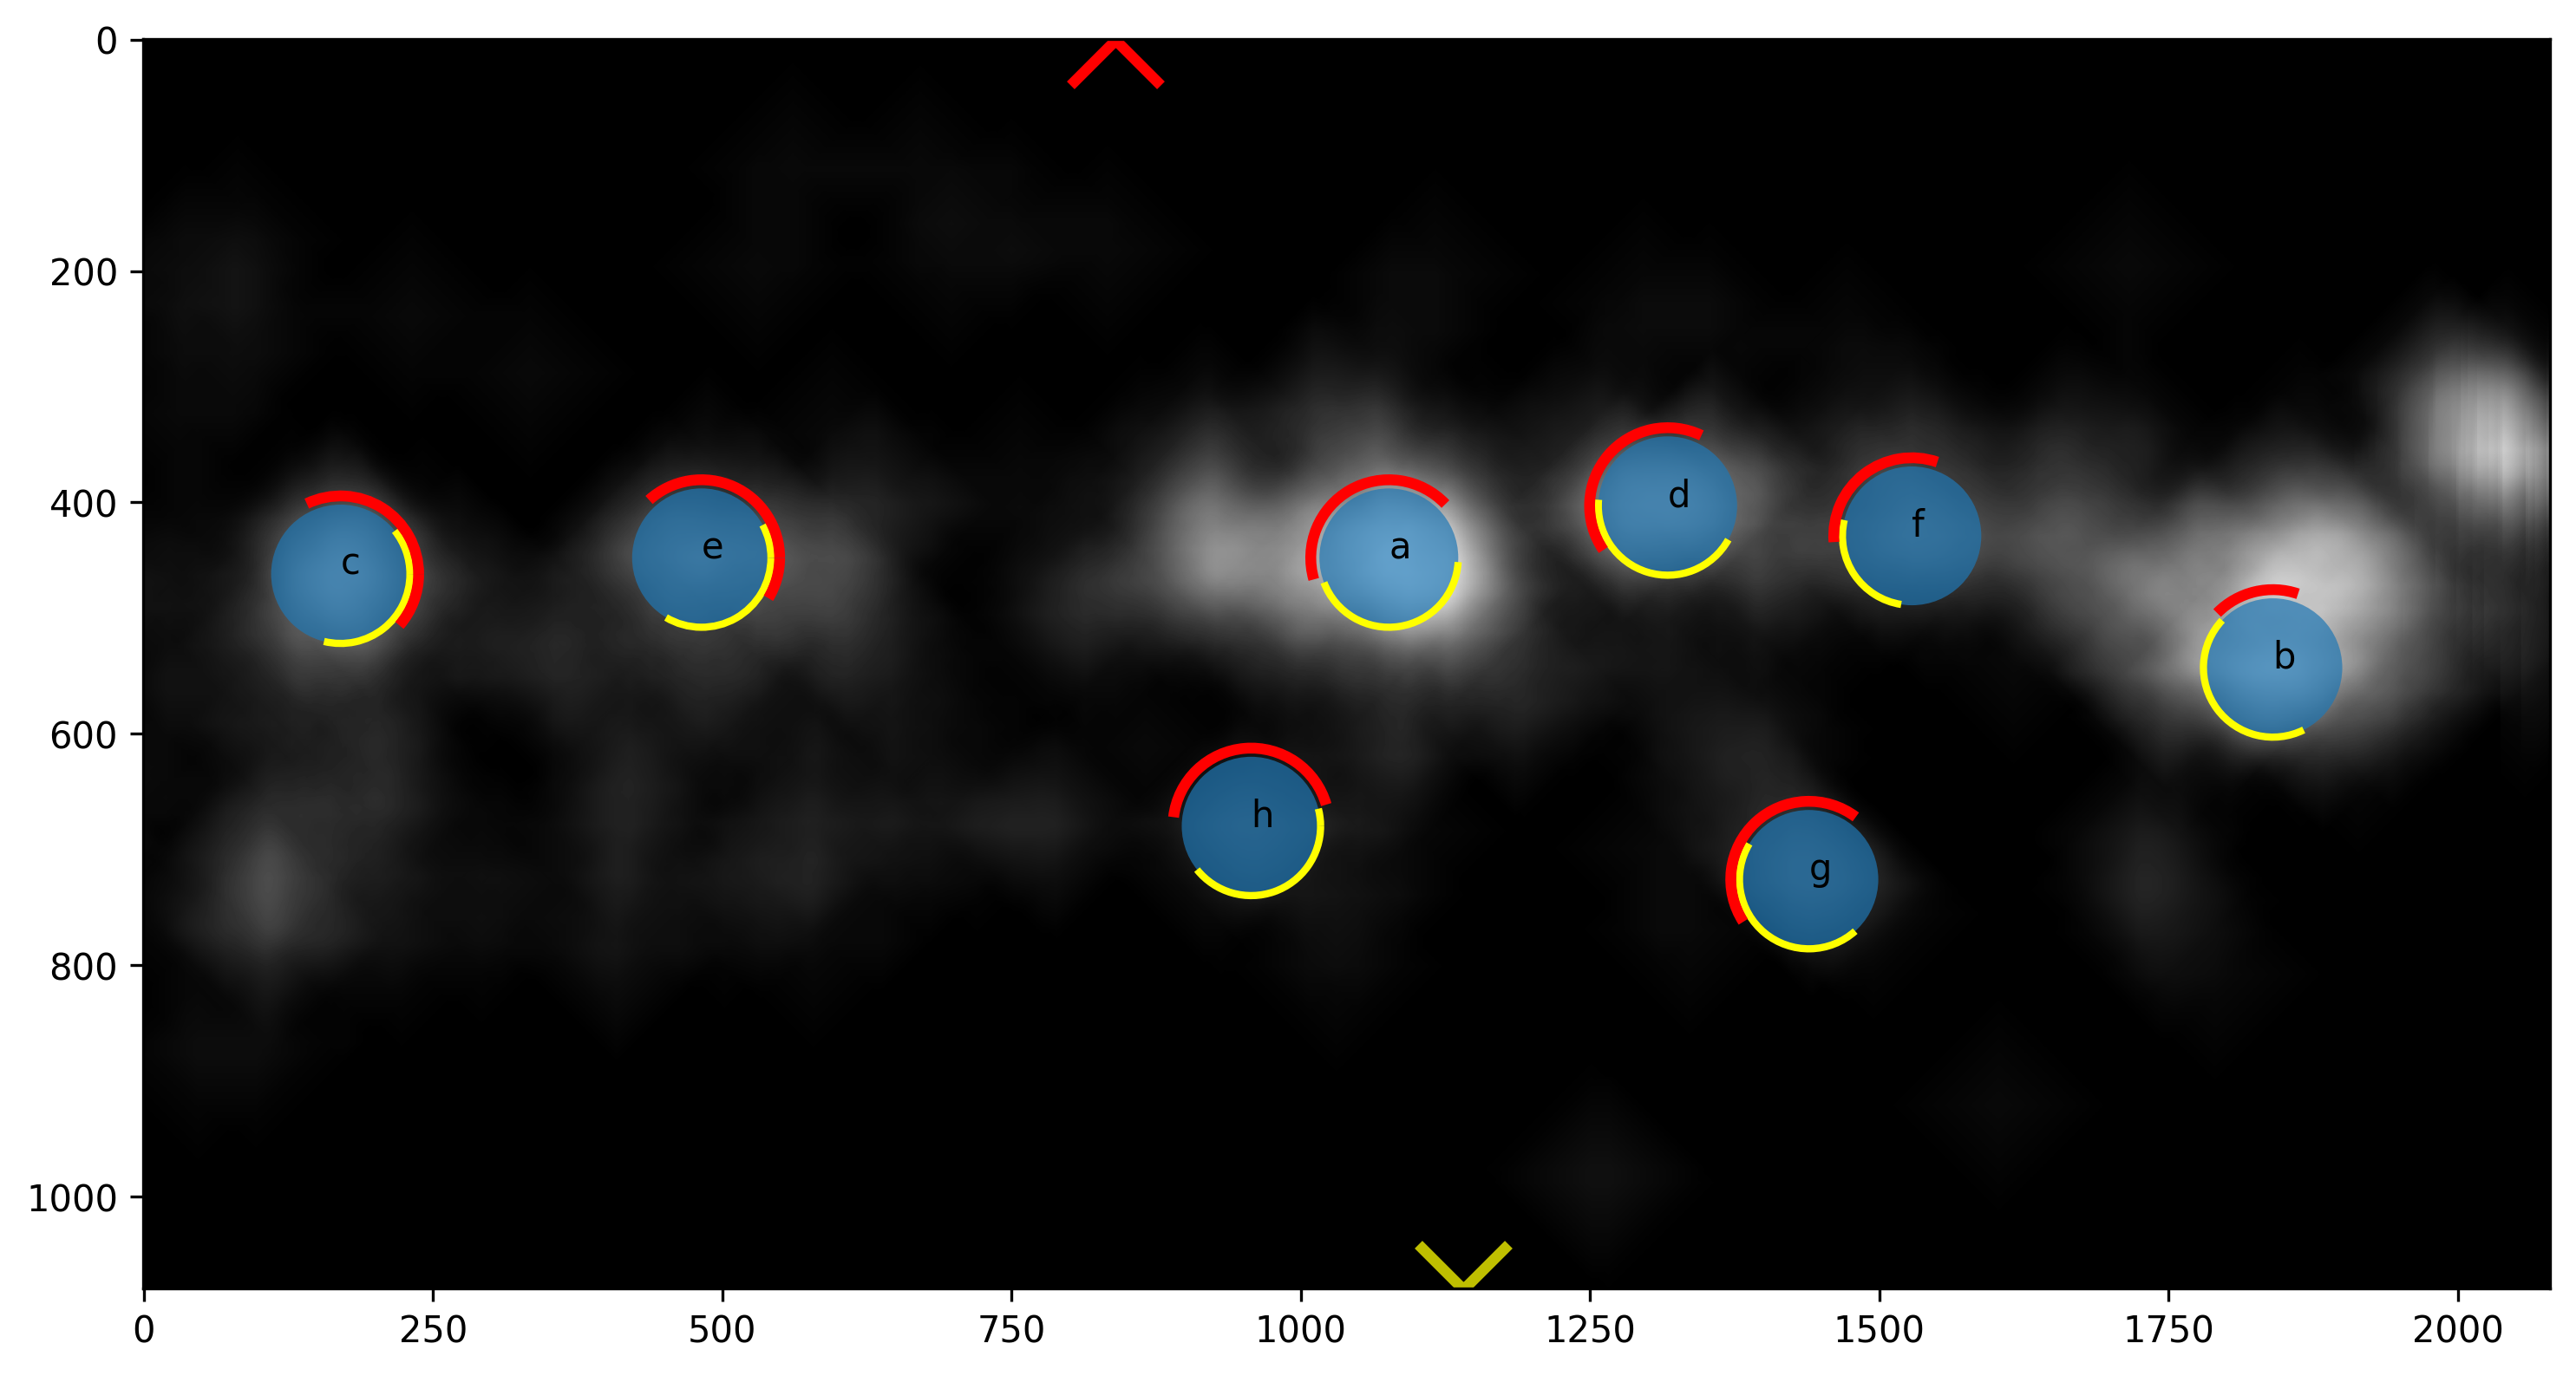

In [15]:
%env RUST_LOG=1
arr = np.c_[peaks, CIRCLE_RADIUS * np.ones(peaks.shape[0])]
options = {
    'width': data.shape[1],
    'height': data.shape[0],
    'resolution': 2880,
    'pixel_step': 10,
}
res, covs = optimize_v2(*arr.T, LETTERS, **options)
plot_from_optimal_coords(data, peaks, res, covs)

In [16]:
%env RUST_LOG=0

NUM_OF_SIM = 50
r = np.array([])

for i in tqdm(range(NUM_OF_SIM)):
    peaks = peak_local_max(data, min_distance=CIRCLE_RADIUS * 2, num_peaks=NUM_PEAKS)
    peaks = peaks + np.random.normal(0, CIRCLE_RADIUS / 4, size=peaks.shape)
    arr = np.c_[peaks, CIRCLE_RADIUS * np.ones(peaks.shape[0])]
    options = {
        'width': data.shape[1],
        'height': data.shape[0],
        'resolution': 2280,
        'pixel_step': 20,
    }
    res, _ = optimize_v2(*arr.T, LETTERS, **options)
    r = np.append(r, res)

env: RUST_LOG=0


100%|███████████████████████████████████████████| 50/50 [02:27<00:00,  2.95s/it]


In [17]:
res = np.array(np.array_split(r, NUM_OF_SIM))

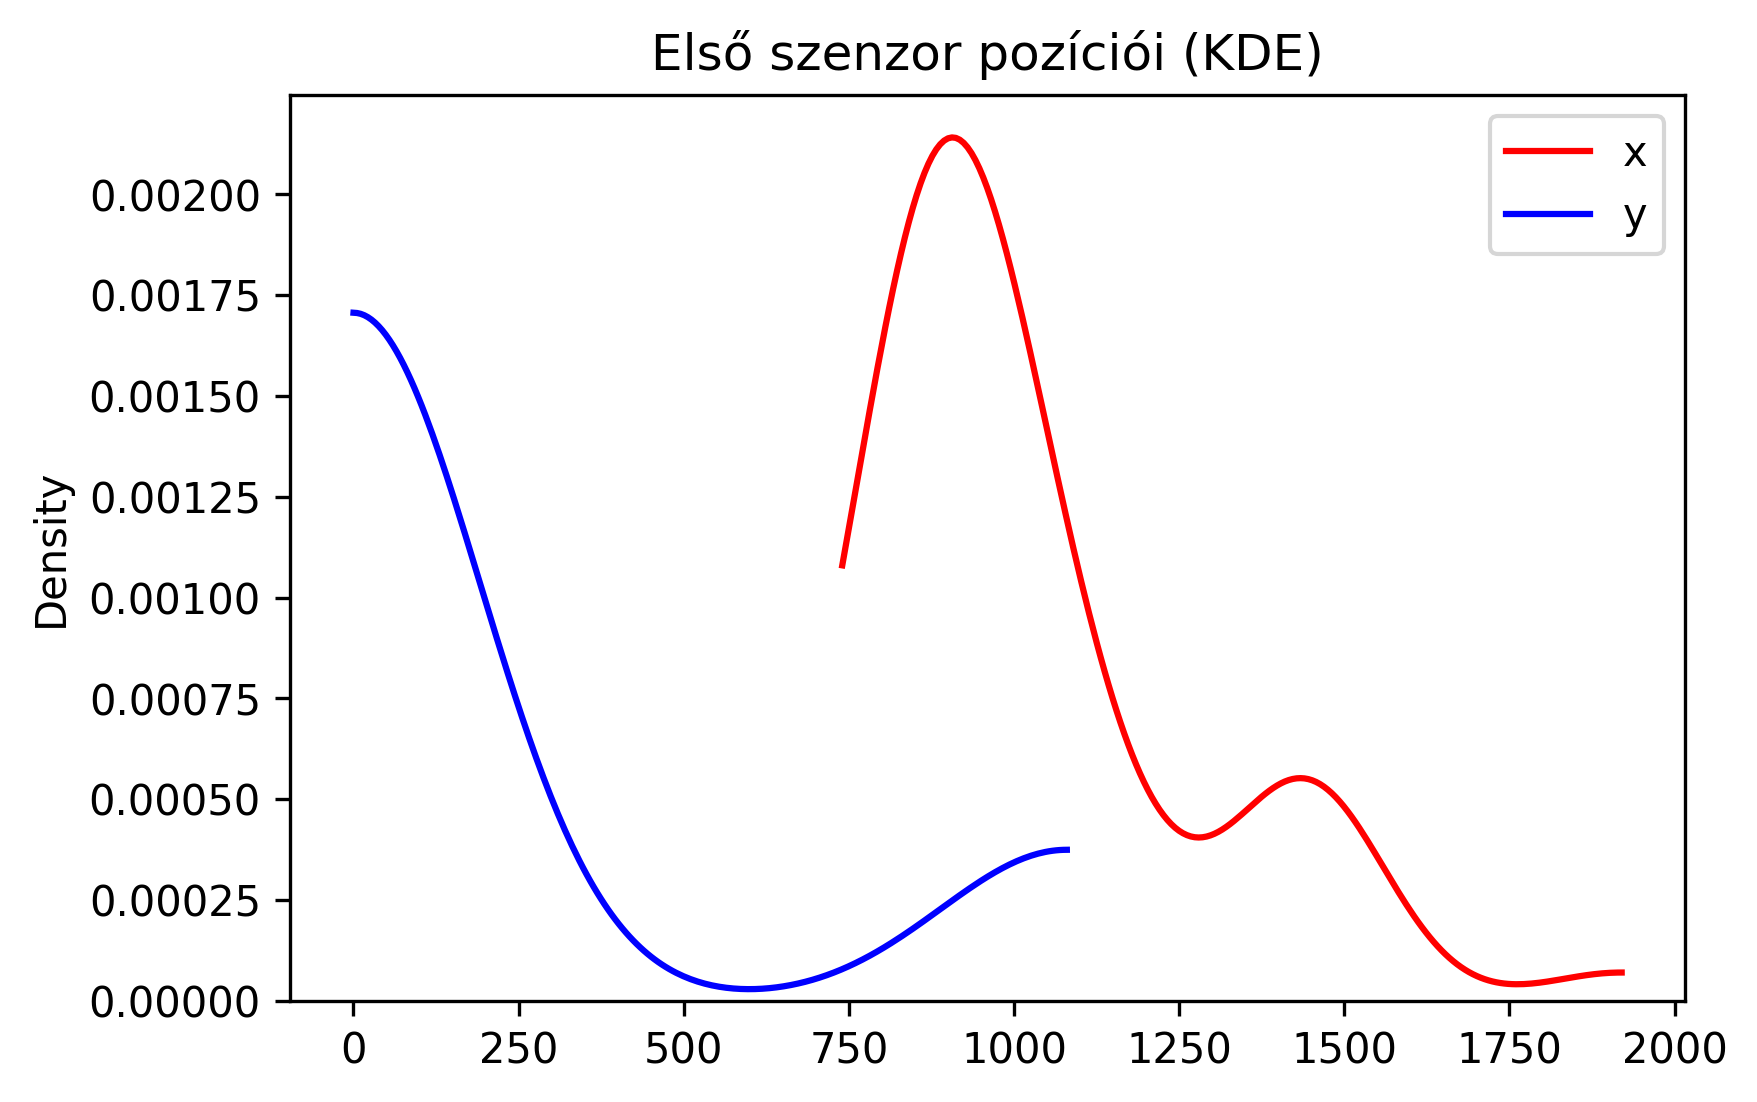

In [18]:
# First sensor
sns.kdeplot(res[:,0], color='red', cut=0, label="x")
sns.kdeplot(res[:,1], color='blue', cut=0, label="y")
plt.title("Első szenzor pozíciói (KDE)")
plt.legend();

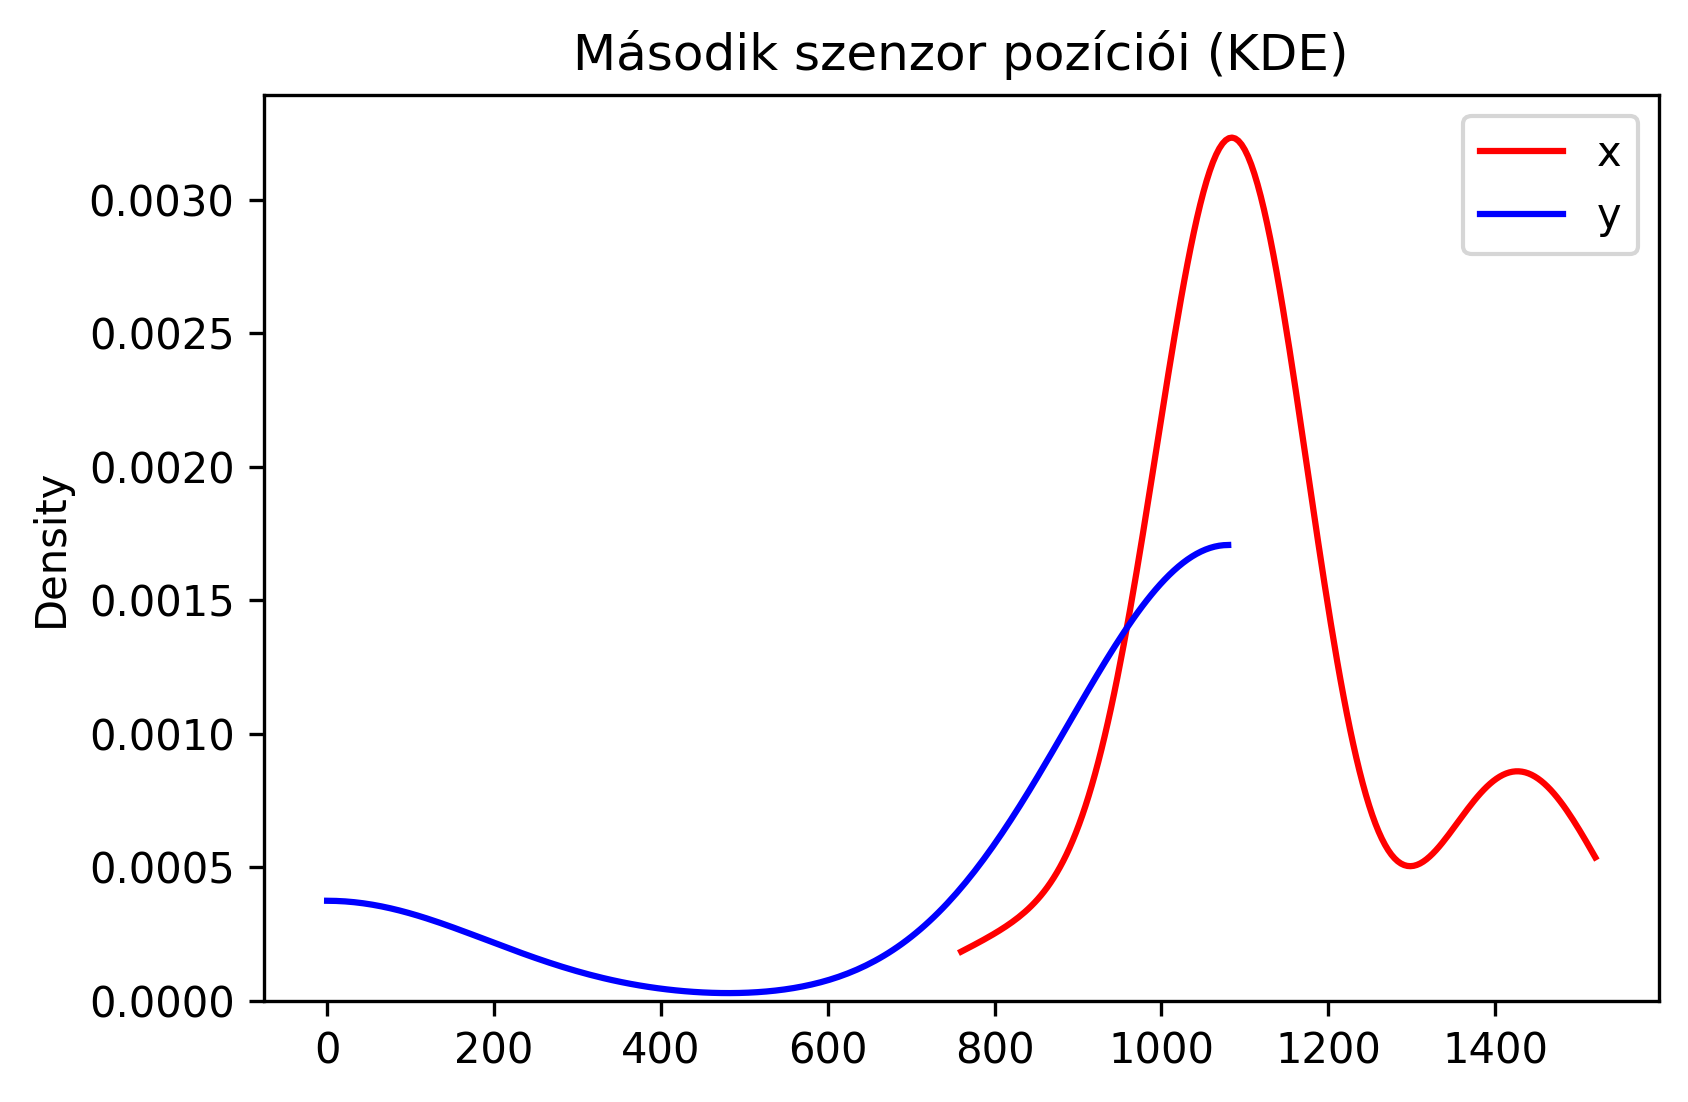

In [19]:
# Second sensor
sns.kdeplot(res[:,2], color='red', cut=0, label="x")
sns.kdeplot(res[:,3], color='blue', cut=0, label="y")
plt.title("Második szenzor pozíciói (KDE)")
plt.legend();

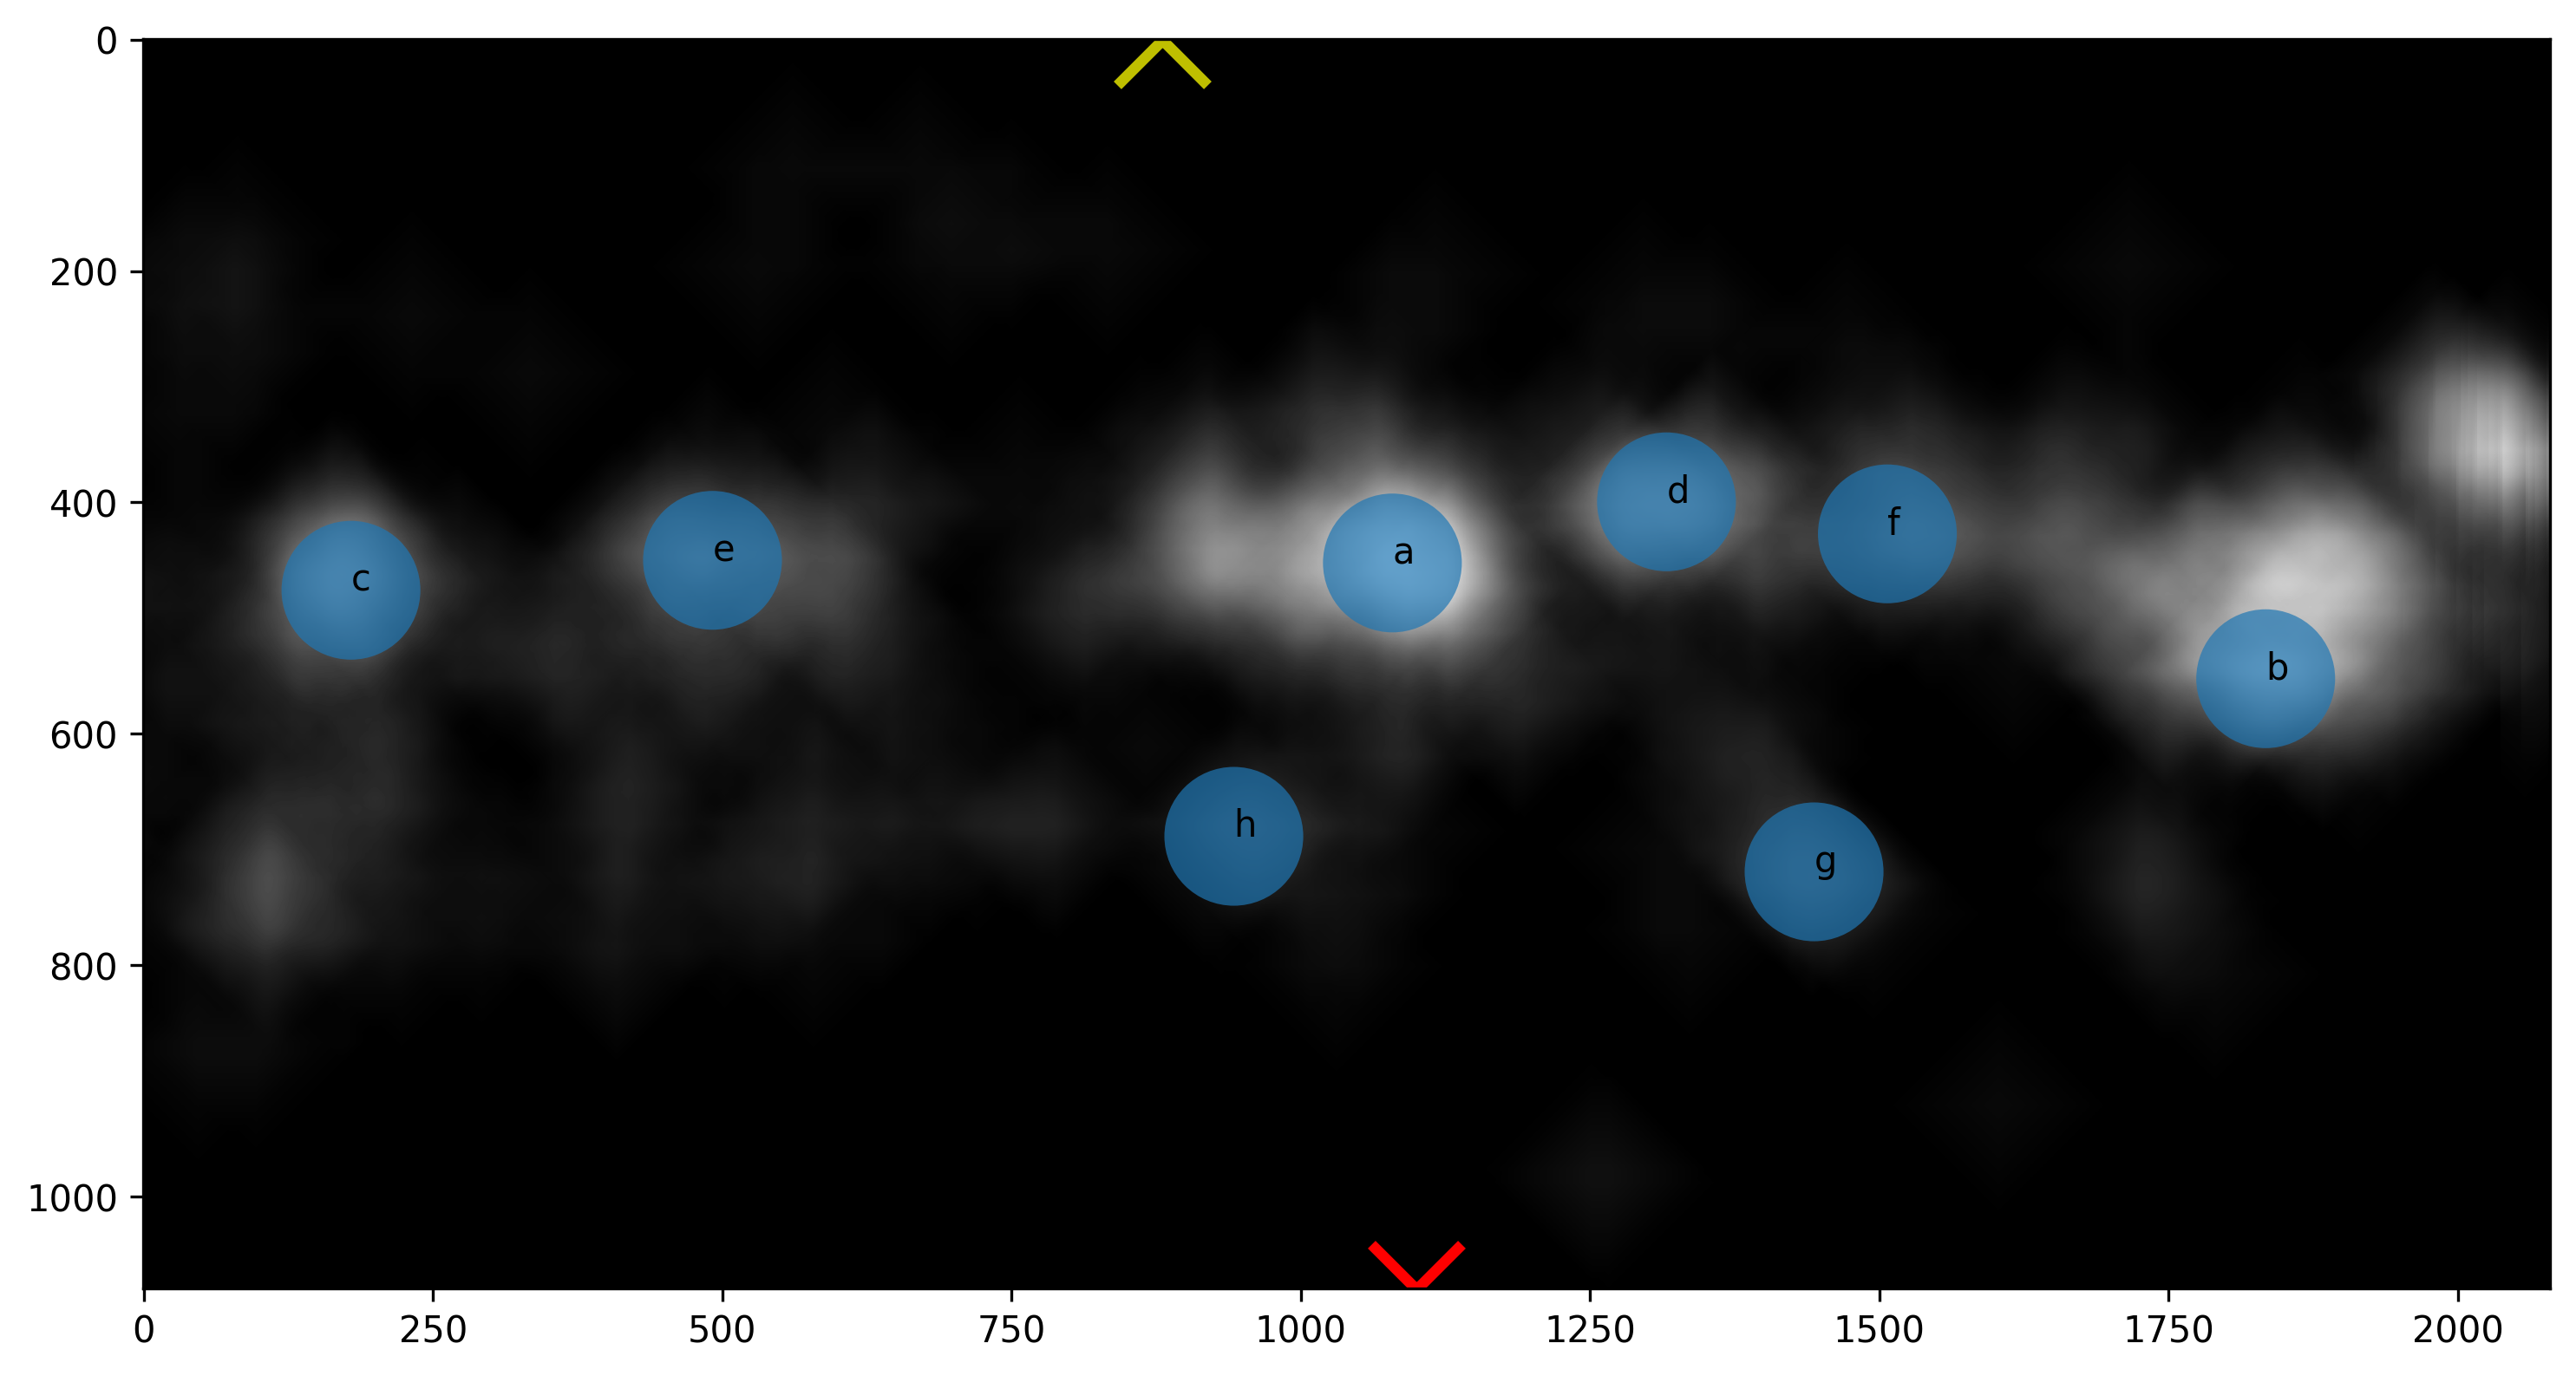

In [20]:
plot_from_optimal_coords(data, peaks, mode(res, axis=0).mode[0])

#### Szimuláció három szenzorral:

env: RUST_LOG=1

🎯 covered 94.27833941066461% (15.084534305706338/16)
✅ optimal positions [
    Point {
        x: 940.0,
        y: 0.0,
    },
    Point {
        x: 2080.0,
        y: 980.0,
    },
    Point {
        x: 0.0,
        y: 1020.0,
    },
]


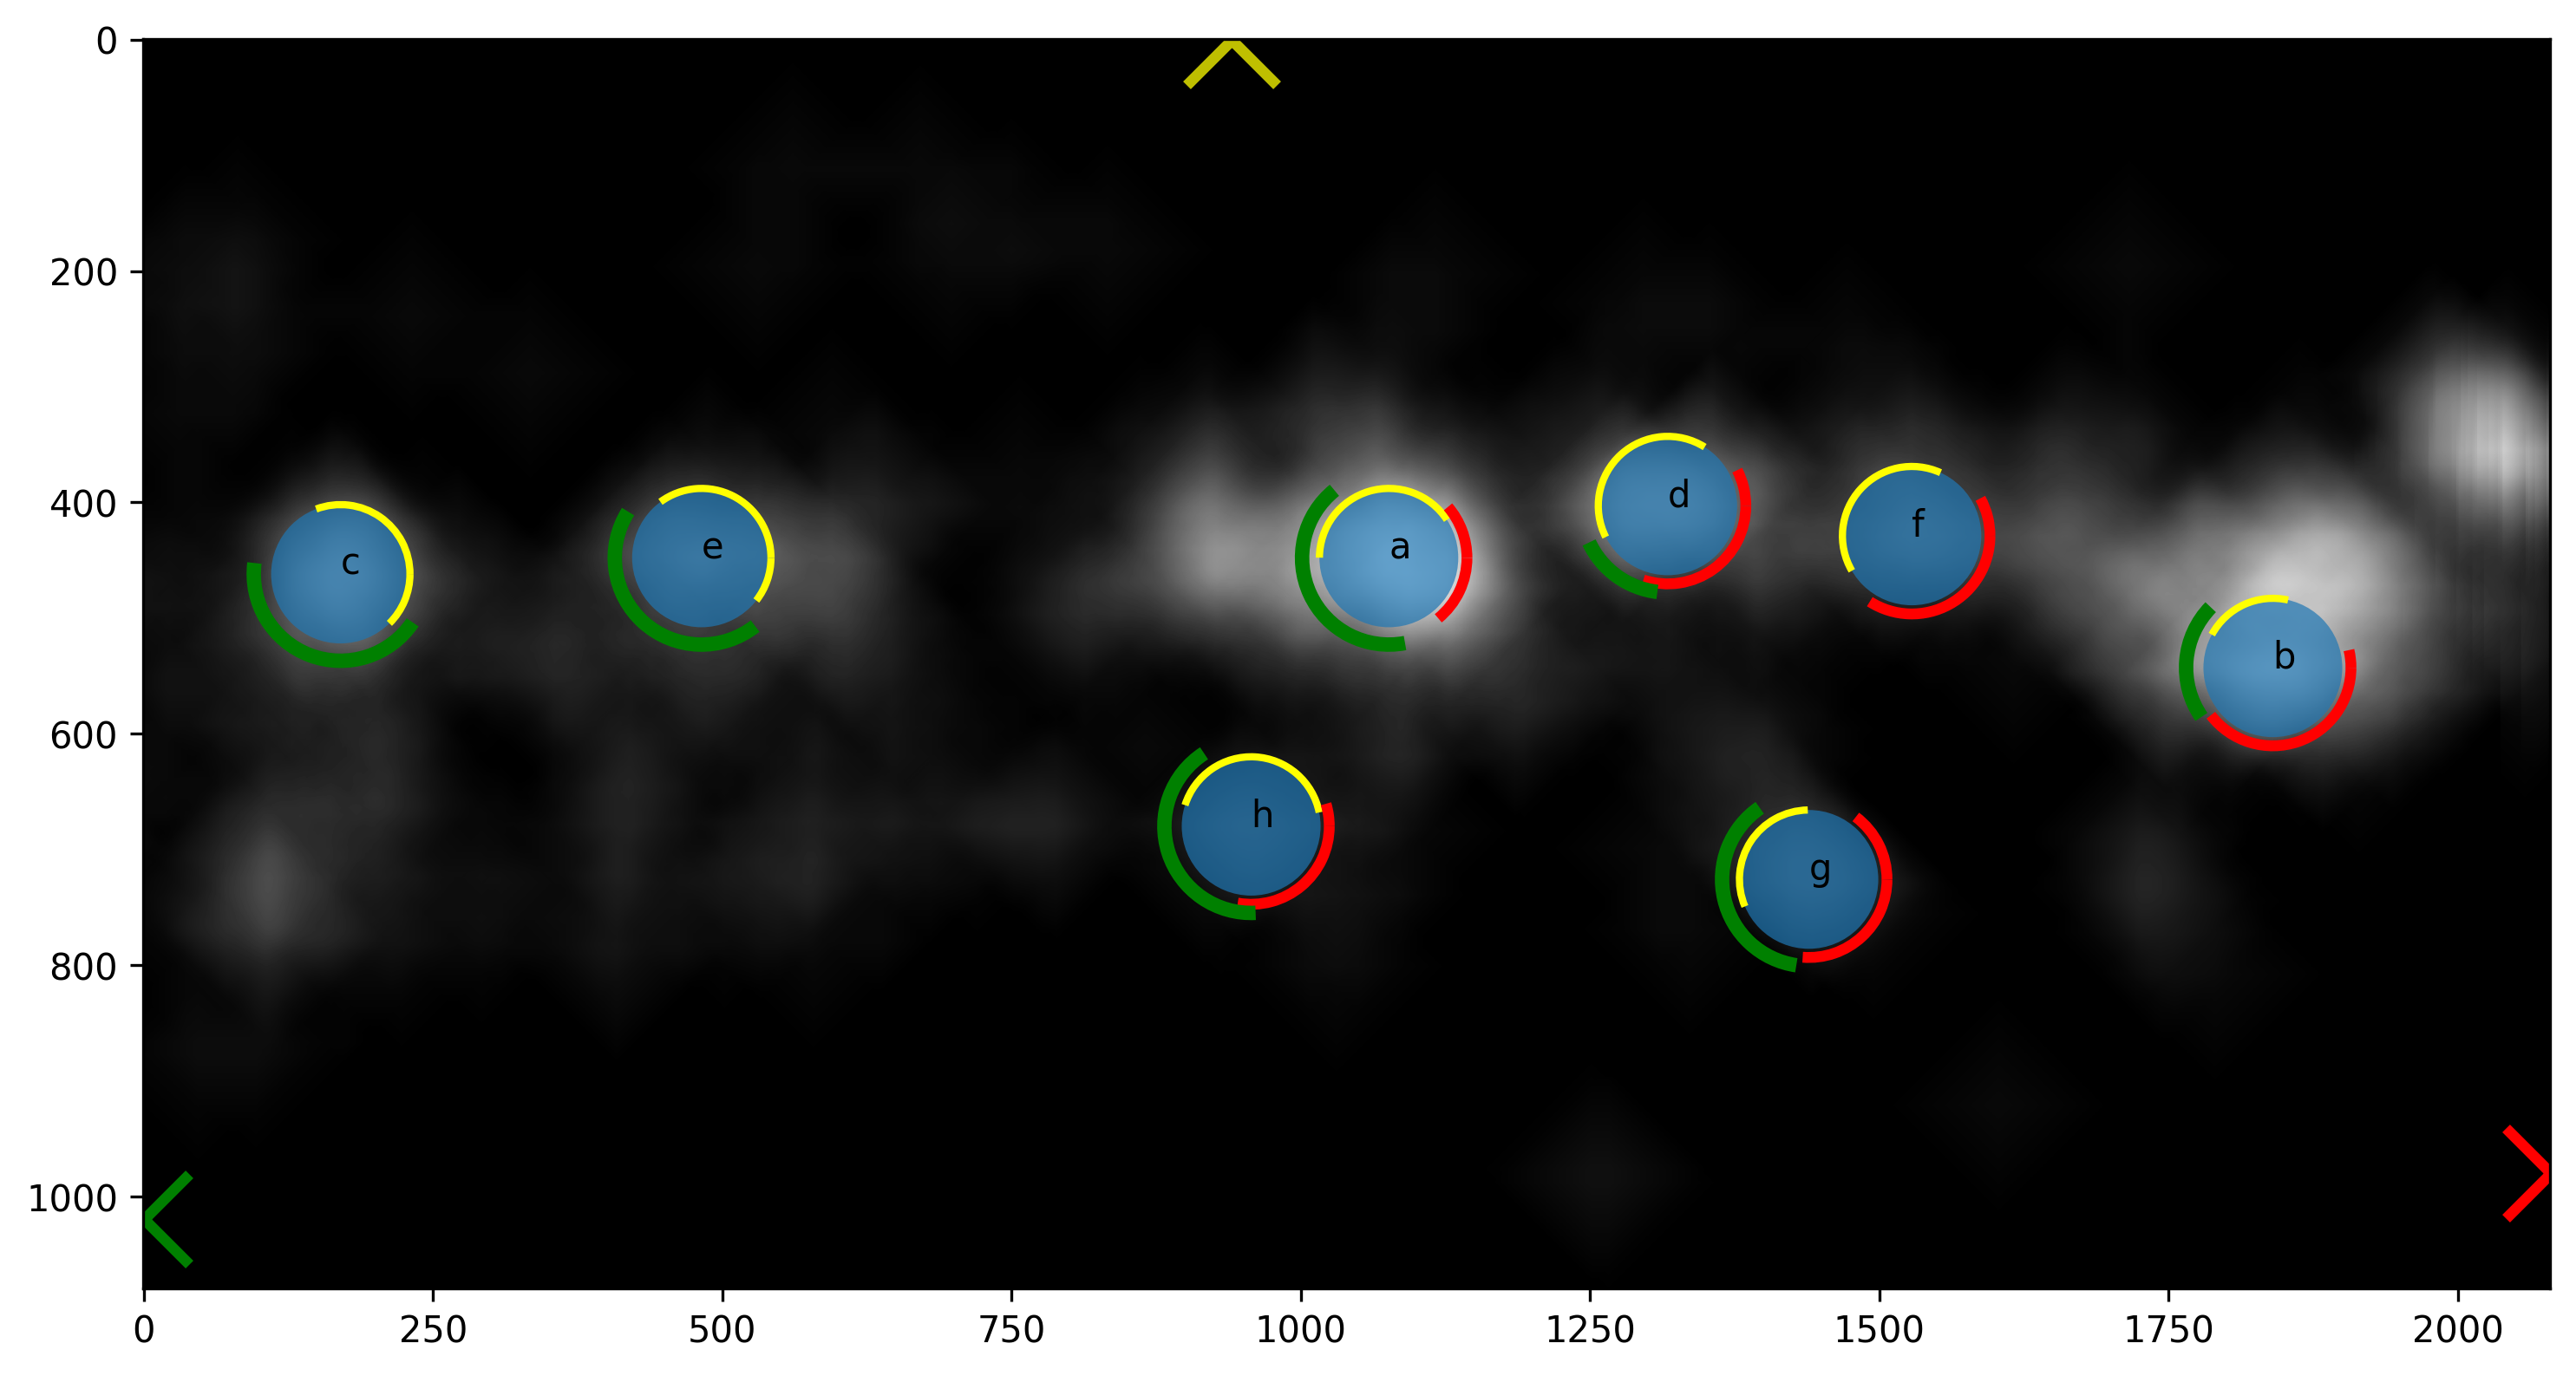

CPU times: user 2h 47min 11s, sys: 50.8 s, total: 2h 48min 1s
Wall time: 15min 14s


In [21]:
%%time
%env RUST_LOG=1

peaks = peak_local_max(data, min_distance=CIRCLE_RADIUS * 2, num_peaks=NUM_PEAKS)
arr = np.c_[peaks, CIRCLE_RADIUS * np.ones(peaks.shape[0])]
options = {
    'width': data.shape[1],
    'height': data.shape[0],
    'resolution': 2280,
    'pixel_step': 20,
}
res, cov = optimize_v3(*arr.T, LETTERS, **options)
plot_from_optimal_coords(data, peaks, res, cov)

### Számolási részletek

Legyen egy $r$ sugarú kör $O(O_x, O_y)$ középponttal, továbbá tekintsünk két $P(P_x, P_y)$ pontból kiinduló sugarat, amelyek $P_1(P_{1x}, P_{1y})$ és $P_2(P_{2x}, P_{2y})$ pontokban metszik a kört (ha több metszéspont is lehetséges, akkor a közelebbit választjuk). Legyen a kör középpontjából a metszéspontokba mutató két szög $\alpha_1$ és $\alpha_2$ standard x-y koordinátarendszerben, amelyek egyszerűen számolhatóak az $atan2(P_{iy} - O_y, P_{ix} - O_x)$ formulával. 

A szimuláció során minden körhöz hozzá van rendelve egy állapot, amely tárolja, hogy mely szögtartományokban van lefedve. Ezek összefedő részei egy adott szenzorállásnál egyesítésre kerülnek, aztán a fennmaradó intervallumok hosszát kiszámolva, majd $2\pi$-vel elosztva megkapjuk, hogy az adott kör hányad része lefedett, vagyis ez adja a fentebb említett $L_i(x)$ függvényt.